In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import signal
import glob
import antropy
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy.signal import butter, sosfilt, sosfreqz, detrend
import math
from scipy.signal import stft,find_peaks
from scipy.stats import kurtosis,skew


### Peak based chewing count estimation based on PSO

In [2]:
sensor_ts_df = pd.read_parquet(r"D:\Angela\NUS\eating_detection\sensor_ts_df_4.parquet")

In [3]:
window_size = 120
window_step = 60
start = 0
end = len(sensor_ts_df) - 1
ts_lst = []
#sensor_ts_df['IMU_2_z_filtered']= pd.Series(filtering(sensor_ts_df['IMU_2_z'],0.1,5,60))
for win_start in range(start,end,window_step):
    win_end = win_start + window_size
    if win_end >= end:
        break
    frame = sensor_ts_df.iloc[win_start:win_end]
    Prox = frame['Prox']
    Prox_frame = Prox.to_frame().T
    Prox_frame.columns = [i for i in range(120)]
    if frame.iloc[-1]['data_pt'] < frame.iloc[0]['data_pt']:
        continue
    if frame['label_eating'].mean() > 0.5:
        Prox_frame['label_eating'] = 1
        Prox_frame['label_chewing_count'] = frame['label_chewing'].sum()
    else:
        Prox_frame['label_eating'] = 0
        Prox_frame['label_chewing_count'] = 0
    Prox_frame['win_start'] = win_start
    Prox_frame['win_end'] = win_end
    ts_lst.append(Prox_frame)
ts_df = pd.concat(ts_lst,axis = 0).reset_index(drop = True)

In [18]:
ts_df

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,label_eating,label_chewing_count,win_start,win_end
0,399.0,400.0,396.0,379.0,374.0,386.0,387.0,383.0,398.0,425.0,...,520.0,516.0,519.0,517.0,507.0,488.0,0,0.0,0,120
1,551.0,559.0,555.0,559.0,608.0,676.0,758.0,869.0,897.0,823.0,...,579.0,622.0,648.0,632.0,626.0,614.0,0,0.0,60,180
2,459.0,414.0,403.0,442.0,454.0,425.0,426.0,462.0,442.0,428.0,...,450.0,462.0,477.0,469.0,463.0,486.0,0,0.0,120,240
3,587.0,573.0,557.0,536.0,507.0,471.0,426.0,398.0,406.0,410.0,...,449.0,453.0,460.0,460.0,465.0,473.0,0,0.0,180,300
4,487.0,454.0,415.0,394.0,392.0,397.0,388.0,384.0,388.0,387.0,...,469.0,472.0,470.0,470.0,472.0,472.0,0,0.0,240,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17791,336.0,334.0,333.0,336.0,338.0,337.0,339.0,345.0,345.0,347.0,...,428.0,425.0,431.0,444.0,450.0,448.0,0,0.0,1075920,1076040
17792,317.0,315.0,315.0,314.0,311.0,311.0,312.0,322.0,331.0,334.0,...,423.0,420.0,415.0,420.0,428.0,429.0,0,0.0,1075980,1076100
17793,437.0,436.0,449.0,457.0,451.0,439.0,434.0,435.0,440.0,457.0,...,437.0,433.0,430.0,429.0,427.0,425.0,0,0.0,1076040,1076160
17794,429.0,432.0,441.0,446.0,441.0,439.0,429.0,420.0,432.0,442.0,...,433.0,431.0,428.0,429.0,423.0,399.0,0,0.0,1076100,1076220


In [4]:
def visualize(ts_df,wid_threshold):
    fig,ax = plt.subplots(2,3,figsize = (20,10))
    eating = ts_df.loc[ts_df['label_eating'] == 1].sample(n=3)
    non_eating = ts_df.loc[ts_df['label_eating'] == 0].sample(n=3)
    for i in range(6):
        if i < 3:
            eating_signal = eating.iloc[i][[x for x in range(120)]]
            count = eating.iloc[i]['label_chewing_count']
            #f_psd, Pxx_dens = signal.periodogram(eating_signal, fs = 60)
            #f,t,Zxx = stft(filtering(eating.iloc[i][[x for x in range(120)]],0.1,3,60),120,nperseg = 20,scaling = 'psd')
            peaks = find_peaks(eating_signal, height = 100,width= wid_threshold)
            ax[0,i].plot([x for x in range(120)],eating.iloc[i][[x for x in range(120)]])
            [ax[0,i].axvline(p, c='C3', linewidth=0.3) for p in peaks[0]]
            #plot_fft(eating.iloc[i],ax[0,i+3])
            #Pxx_dens_dB = 10*np.log10(Pxx_dens/Pxx_dens.max())
            #ax[0,i+3].plot(f_psd,Pxx_dens_dB)
            ##ax[0,i+3].plot(f,(np.abs(Zxx)**4).mean(axis = 1) / ((np.abs(Zxx)**2).mean(axis = 1))**2 - 2)
            ##ax[0,i+3].plot(f,Pxx_dens)
            print(count)
        else:
            non_eating_signal = non_eating.iloc[i-3][[x for x in range(120)]]
            #f_psd, Pxx_dens = signal.periodogram(non_eating.iloc[i-3][[x for x in range(120)]], fs = 60)
            ##f,t,Zxx = stft(filtering(non_eating.iloc[i-3][[x for x in range(120)]],0.1,3,60),120,nperseg = 20,scaling = 'psd')
            ax[1,(i-3)].plot([x for x in range(120)],non_eating.iloc[i-3][[x for x in range(120)]])
            peaks = find_peaks(non_eating_signal, height = 100,width=wid_threshold)
            [ax[1,(i-3)].axvline(p, c='C3', linewidth=0.3) for p in peaks[0]]
            #plot_fft(non_eating.iloc[i-3],ax[1,i])
            #Pxx_dens_dB = 10*np.log10(Pxx_dens/Pxx_dens.max())
            #ax[1,i].plot(f_psd,Pxx_dens_dB)
            ##ax[1,i].plot(f,(np.abs(Zxx)**4).mean(axis = 1) / ((np.abs(Zxx)**2).mean(axis = 1))**2 - 2)
            ##ax[1,i].plot(f,Pxx_dens)
    plt.show()

3.0
0.0
0.0


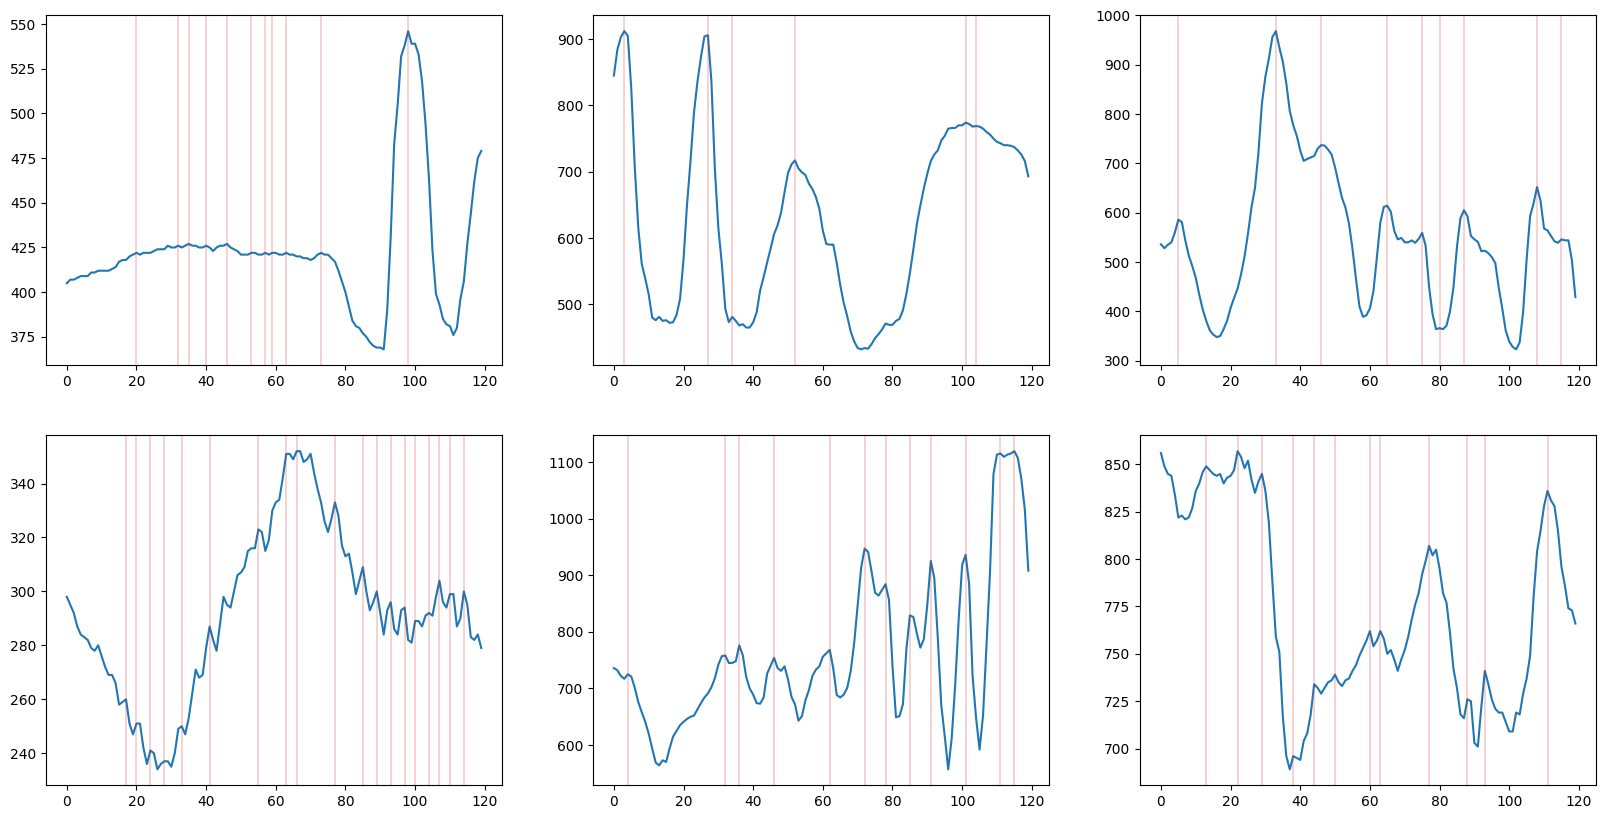

In [5]:
visualize(ts_df,1)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def cost_function(p,input_signal):
    prom_multiplier = p[0]
    width_multiplier = p[1]
    err_rate_lst = []
    for index,row in input_signal.iterrows():
        signal = row[[i for i in range(120)]]
        _,properties = find_peaks(signal,prominence = 1,width = 1)
        mean_prominence = np.mean(properties['prominences'])
        mean_width = np.mean(properties['widths'])
        exp_pk = len(find_peaks(signal,prominence = mean_prominence*prom_multiplier,width = mean_width*width_multiplier)[0])
        err_rate = abs(exp_pk - row['label_chewing_count'])/row['label_chewing_count']
        err_rate_lst.append(err_rate)
    return np.array(err_rate_lst).mean()
    
    

def pso(cost_func, data_input,dim=2, num_particles=30, max_iter=30, w=0.5, c1=1, c2=2):

    particles = np.random.uniform(0, 3, (num_particles, dim))
    velocities = np.zeros((num_particles, dim))
    best_fitness_lst = []

    best_positions = np.copy(particles)
    best_fitness = np.array([cost_func(p,data_input) for p in particles])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)

    for i in range(max_iter):
        r1 = np.random.uniform(0, 1, (num_particles, dim))
        r2 = np.random.uniform(0, 1, (num_particles, dim))
        velocities = w * velocities + c1 * r1 * (best_positions - particles) + c2 * r2 * (swarm_best_position - particles)

        particles += velocities

        fitness_values = np.array([cost_func(p,data_input) for p in particles])

        improved_indices = np.where(fitness_values < best_fitness)
        best_positions[improved_indices] = particles[improved_indices]
        best_fitness[improved_indices] = fitness_values[improved_indices]
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)
        print(f'iter:{i}')
        print(f'fitness:{swarm_best_fitness}')
        best_fitness_lst.append(swarm_best_fitness)

    return swarm_best_position, swarm_best_fitness, best_fitness_lst


In [23]:
Prox_total = ts_df.loc[(ts_df['label_eating'] == 1) & (ts_df['label_chewing_count']!=0)]

In [25]:
train = Prox_total.sample(frac = 0.75)
test = Prox_total.drop(train.index)

In [26]:
dim = 2

solution, fitness, train_hist = pso(cost_func = cost_function,data_input = train, dim=dim)

print('Solution:', solution)
print('Fitness:', fitness)

iter:0
fitness:0.4744899952758112
iter:1
fitness:0.4744899952758112
iter:2
fitness:0.4744899952758112
iter:3
fitness:0.4744899952758112
iter:4
fitness:0.47128790684140615
iter:5
fitness:0.47128790684140615
iter:6
fitness:0.47128790684140615
iter:7
fitness:0.47128790684140615
iter:8
fitness:0.47128790684140615
iter:9
fitness:0.47128790684140615
iter:10
fitness:0.4695872892212586
iter:11
fitness:0.4662229416251075
iter:12
fitness:0.4662229416251075
iter:13
fitness:0.46581051065033796
iter:14
fitness:0.4654475667504385
iter:15
fitness:0.4654475667504385
iter:16
fitness:0.4654475667504385
iter:17
fitness:0.4654475667504385
iter:18
fitness:0.4653963451144194
iter:19
fitness:0.4653963451144194
Solution: [1.16307947 0.94122321]
Fitness: 0.4653963451144194


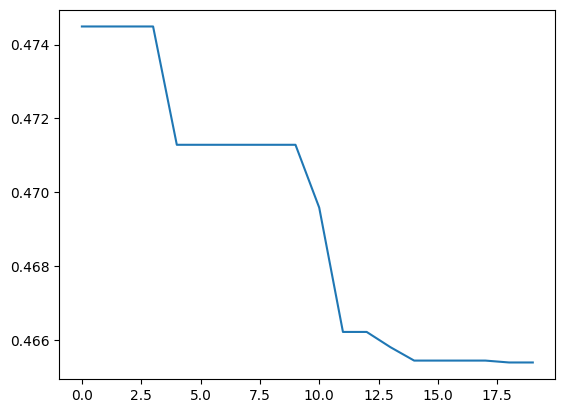

In [27]:
plt.plot([i for i in range(20)],train_hist)